In [39]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2  # OpenCV
from tqdm import tqdm 
import random
from fastai.vision.all import *
from fastai.data.block import DataBlock
from sklearn.metrics import confusion_matrix
import joblib
import pickle
from shutil import copyfile

In [15]:
import pandas as pd

# Read the CSV file
data = pd.read_csv("Data_Entry_2017.csv")

# Select only the columns "Image Index" and "Finding Labels"
selected_columns = data[["Image Index", "Finding Labels"]]

df = selected_columns

In [16]:
df

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_000.png,Hernia
...,...,...
112115,00030801_001.png,Mass|Pneumonia
112116,00030802_000.png,No Finding
112117,00030803_000.png,No Finding
112118,00030804_000.png,No Finding


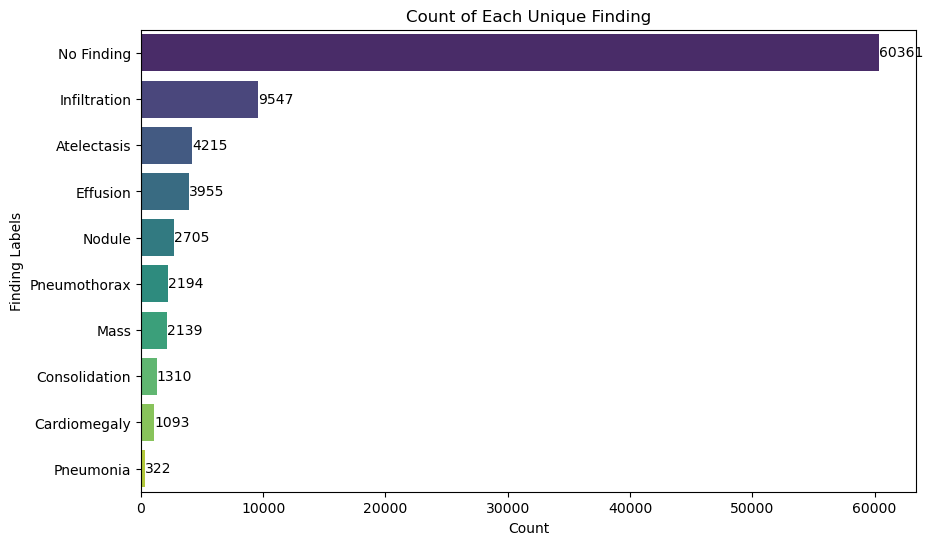

In [48]:
# Count the occurrences of each unique finding
finding_counts = filtered_df['Finding Labels'].value_counts()

# Plot the count of each unique finding
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=finding_counts.values, y=finding_counts.index, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Finding Labels')
plt.title('Count of Each Unique Finding')

# Annotate each bar with its count
for i, count in enumerate(finding_counts.values):
    ax.text(count, i, str(count), va='center')

plt.show()

In [47]:
# Define paths
data_folder = "Data"
image_folders = [
    "images_001", "images_002", "images_003", "images_004", "images_005",
    "images_006", "images_007", "images_008", "images_009", "images_010",
    "images_011", "images_012"
]
output_folder = "images"
allowed_labels = ["Atelectasis", "Cardiomegaly", "Effusion", "Infiltration",
                  "Mass", "Nodule", "Pneumonia", "Pneumothorax",
                  "Consolidation", "No Finding"]

# Read DataFrame
df = pd.read_csv("Data_Entry_2017.csv")  # Replace "your_dataframe.csv" with your actual file path

# Create output folder if not exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Loop through allowed labels
for label in allowed_labels:
    # Create folder for current label
    label_folder = os.path.join(output_folder, label)
    if not os.path.exists(label_folder):
        os.makedirs(label_folder)
    
    # Copy images for the current label
    count = 0
    for index, row in df.iterrows():
        if label in row['Finding Labels']:
            # Find the image folder
            for folder in image_folders:
                if os.path.exists(os.path.join(data_folder, folder, row['Image Index'])):
                    src = os.path.join(data_folder, folder, row['Image Index'])
                    dst = os.path.join(label_folder, row['Image Index'])
                    shutil.copyfile(src, dst)
                    count += 1
                    if count >= 1000 or count >= len(df[df['Finding Labels'].str.contains(label)]):
                        break
            else:
                continue
            break

print("Images copied successfully!")

Images copied successfully!


In [52]:
# Define paths
data_folder = "images"
batch_size = 64
image_size = 224

# Set up data augmentation and transformation
item_tfms = Resize(image_size)


# Create a datablock
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   get_y=parent_label,
                   item_tfms=item_tfms)

# Load the data using the datablock
dls = dblock.dataloaders(data_folder, bs=batch_size)

epoch,train_loss,valid_loss,accuracy,time
0,3.170654,2.464658,0.169000,07:37


epoch,train_loss,valid_loss,accuracy,time
0,2.538561,2.290847,0.236500,08:33
1,2.167419,2.168253,0.233500,08:45
2,1.577984,2.196460,0.262000,08:39


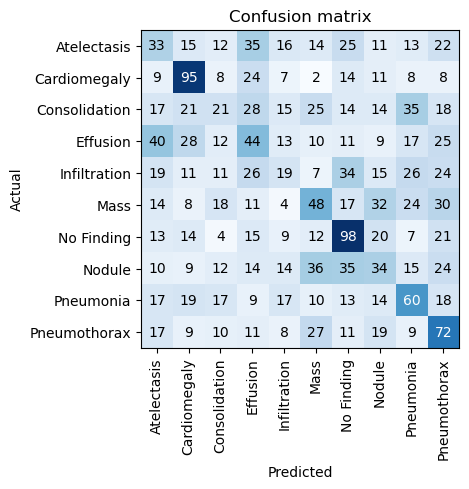

In [53]:
# Choose ResNet model
learn = vision_learner(dls, resnet34, metrics=accuracy)

# Train the model
learn.fine_tune(3)

# Evaluate the model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [54]:
learn.export()